This data comes from the extremely hard work of wonderful scientists. It was ollected by Alex Huth and Wendy de Heer at the University of California, Berkeley. All work was supervised by professors Jack Gallant and Frederic Theunissen of the UC Berkeley Psychology Department. Please do not redistribute the code or data used here. Visualization is done using [pycortex](http://pycortex.org).

#### Citation
The analysis demonstrated in this tutorial forms the basis of this paper:
[Huth, A. G. et al., "Natural speech reveals the semantic maps that tile human cerebral cortex" (2016) _Nature_.](https://www.nature.com/articles/nature17637)

This data was retrieved following the tutorial at https://github.com/HuthLab/speechmodeltutorial then add the below cell to save out the outputs used here.

In [54]:
from cProfile import label
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import numpy as np
from tqdm import tqdm
import pickle as pkl
import cortex # brain viz library

def flatmap_quickshow(scores, mask, with_rois=True, with_labels=True,
                      vmin=0, vmax=0.5, cmap=cm.hot):
    """
    rois & labels require inkscape

    # there's also a fancy web version
    # cortex.webshow(corrvol, port=8889, open_browser=False)
    """

    corrvol = cortex.Volume(scores, "S1", "fullhead",
                            mask=mask, vmin=vmin, vmax=vmax, cmap=cmap)
    cortex.quickshow(corrvol, with_rois=with_rois, with_labels=with_labels, colorbar_location='right')

def plot_mosaic(scores, mask, vmin=0, vmax=0.5, cmap=cm.hot):
    """Plot mosaic of scores given a mask
    """
    corrvolume = np.zeros(mask.shape)
    corrvolume[mask>0] = scores

    plt.figure(figsize=(10, 10))
    cortex.mosaic(corrvolume, vmin=vmin, vmax=vmax, cmap=cmap);

def remap_scores_best_to_scores_all(scores_best_voxels, corrsort):
    """We are only looking at the best voxels (in the order of corrsort).
    Before plotting, we need to map back.
    """
    scores_all_voxels = np.zeros(corrsort.size)
    for i in range(scores_best_voxels.size):
        vox_num = corrsort[i]
        scores_all_voxels[vox_num] = scores_best_voxels[i]
    return scores_all_voxels

# Load the data

For this to work, need to put the `best_voxels_top_words_1000.pkl` (results for the best 1000 voxels) and the `voxels_metadata.pkl` files into the neuro_processed directory.

In [55]:
meta = pkl.load(open('neuro_processed/voxels_metadata.pkl', 'rb'))
top_words = pkl.load(open('neuro_processed/best_voxels_top_words_7000.pkl', 'rb'))

# Exploring the top_words

# Plotting prediction performance (correlations) of each voxel model
Note: in order to plot need to map back to the ordering used by the mask and the corr (best_voxels are sorted in order of corrsort). Here, we show a couple different kind of plots.

**Imagine we got a score for each of our N_top voxels. How would we plot them?**

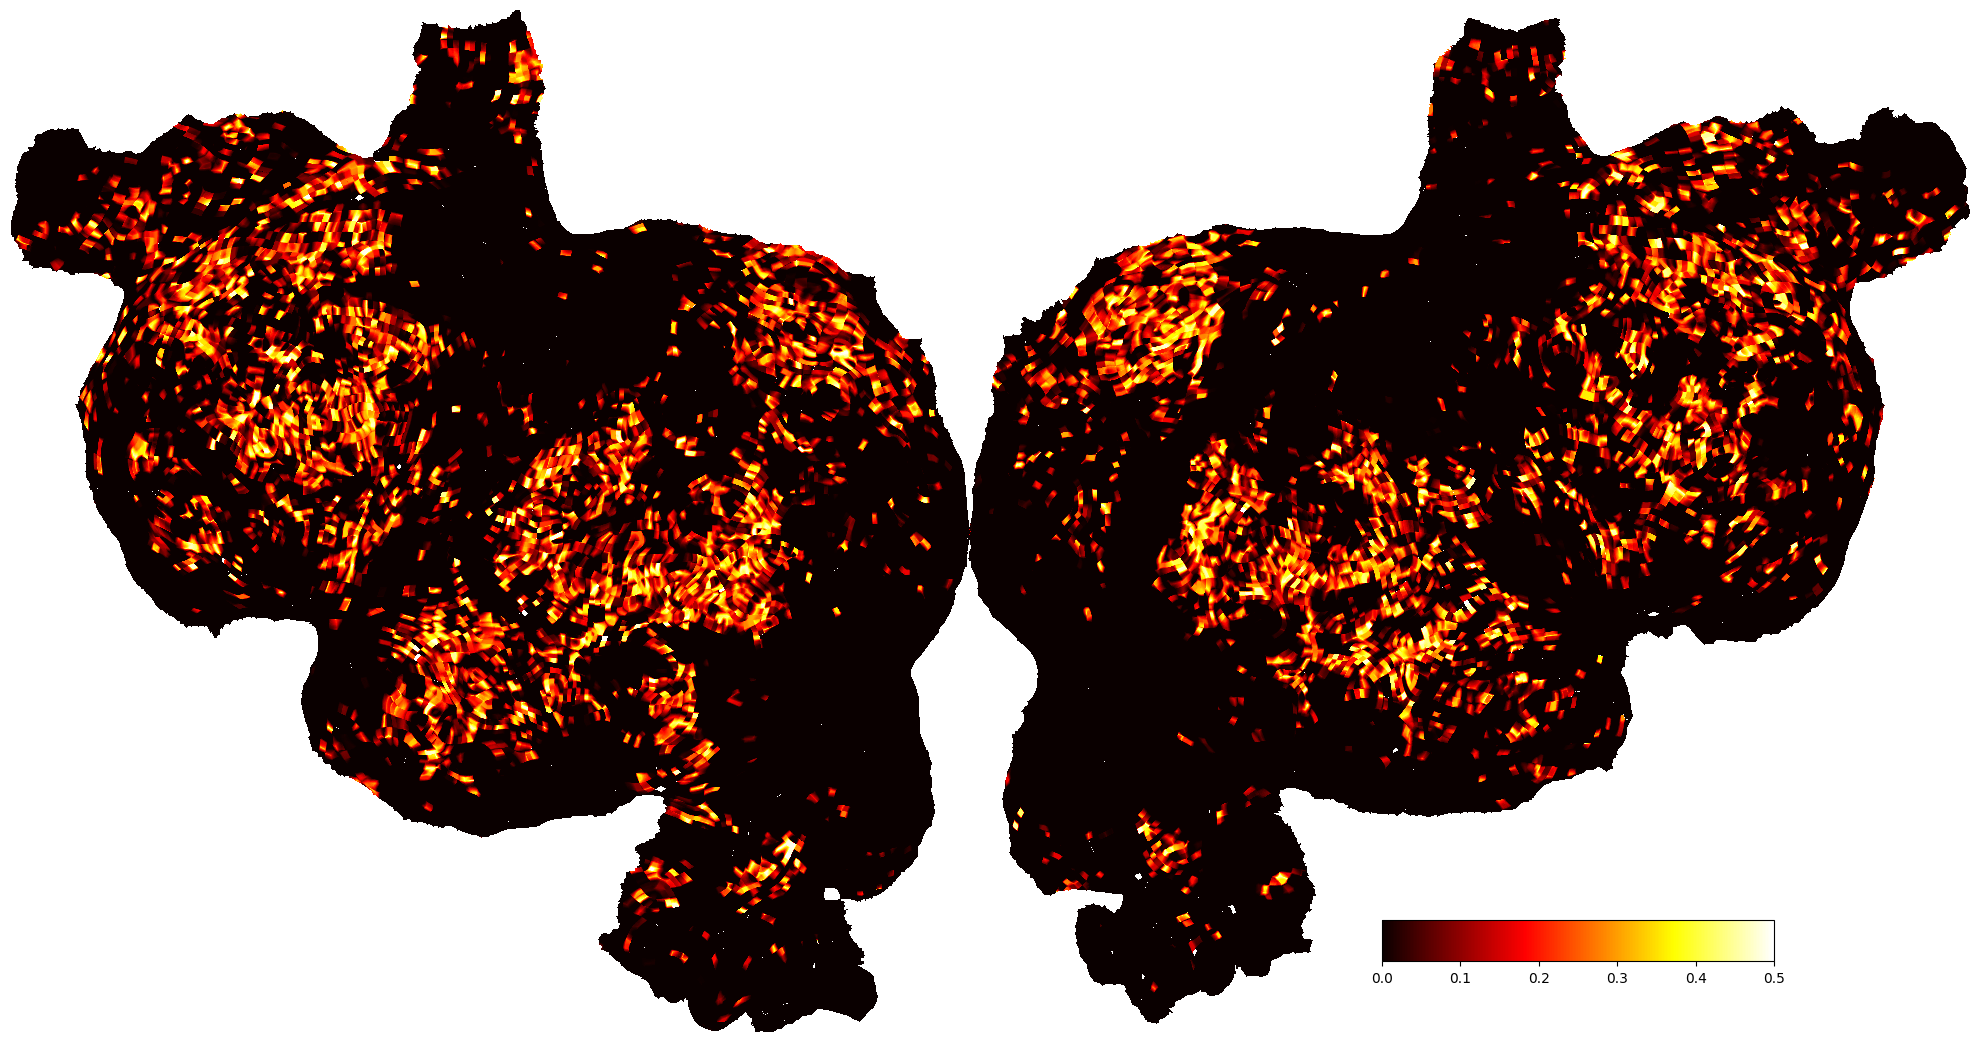

In [53]:
N_top = top_words['top_words'].shape[0]
fake_scores_best = np.random.uniform(low=0, high=0.5, size=N_top)
fake_scores_reshaped = remap_scores_best_to_scores_all(fake_scores_best, meta['corrsort'])

flatmap_quickshow(fake_scores_reshaped, meta['mask'], with_rois=False, with_labels=False)

**Plotting 2D**

/home/chansingh/.autoprompt/lib/python3.8/site-packages/cortex/quickflat/utils.py:497: UserWarning: Trying to register the cmap 'PU_BuOr_covar' which already exists.
  cm.register_cmap(dataview.cmap, cmap)


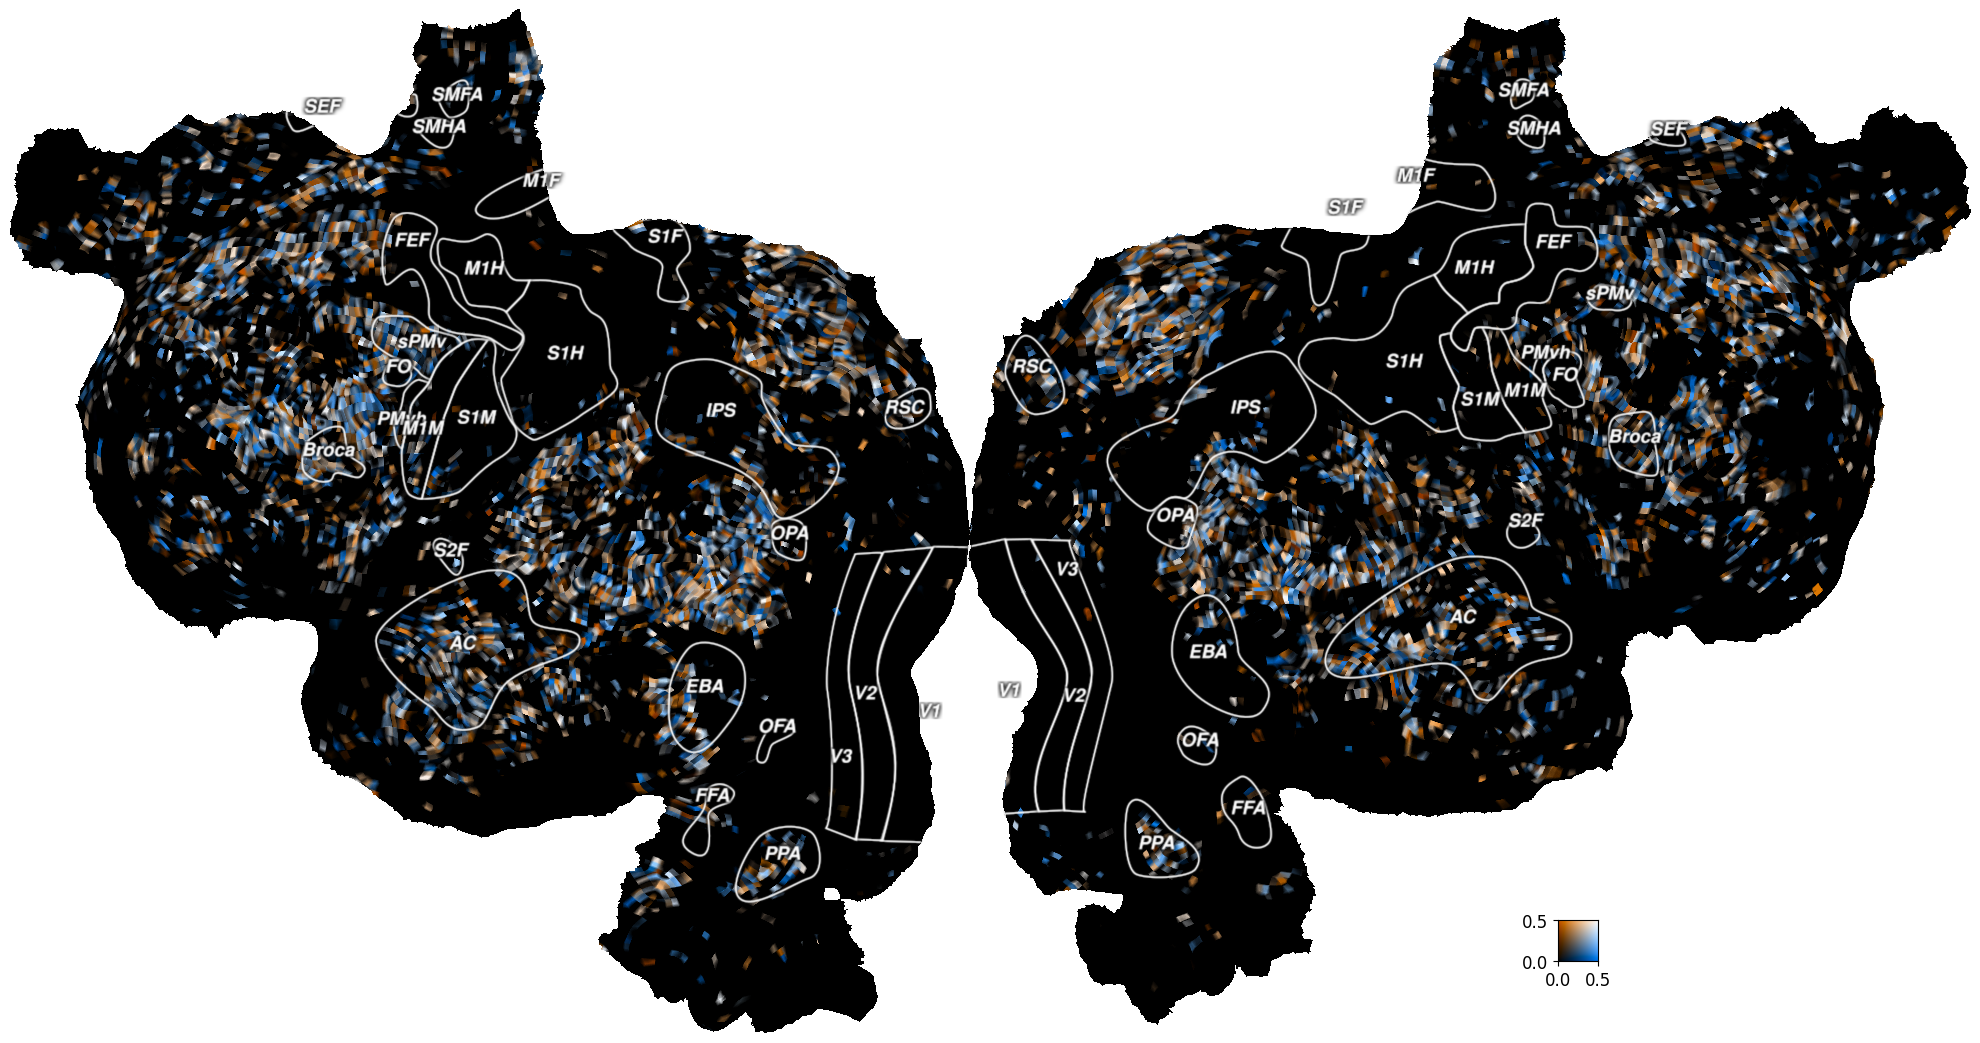

In [47]:
N_top = top_words['top_words'].shape[0]
fake_scores_best2 = np.random.uniform(low=0, high=0.5, size=N_top)
fake_scores_reshaped2 = remap_scores_best_to_scores_all(
    fake_scores_best2, meta['corrsort'])

s1 = np.zeros(meta['mask'].shape)
s1[meta['mask'] > 0] = fake_scores_reshaped
s2 = np.zeros(meta['mask'].shape)
s2[meta['mask'] > 0] = fake_scores_reshaped2

vol_data = cortex.Volume2D(s1, s2, "S1", "fullhead",
                           mask=meta['mask'],
                           vmin=np.min(s1), vmax=np.max(s1),
                           vmin2=np.min(s2), vmax2=np.max(s2),
                           cmap='BuOr_2D'
                           )
cortex.quickshow(vol_data, with_colorbar=True, colorbar_location='right')
plt.show()


### We can also plot the prediction performance of different voxels

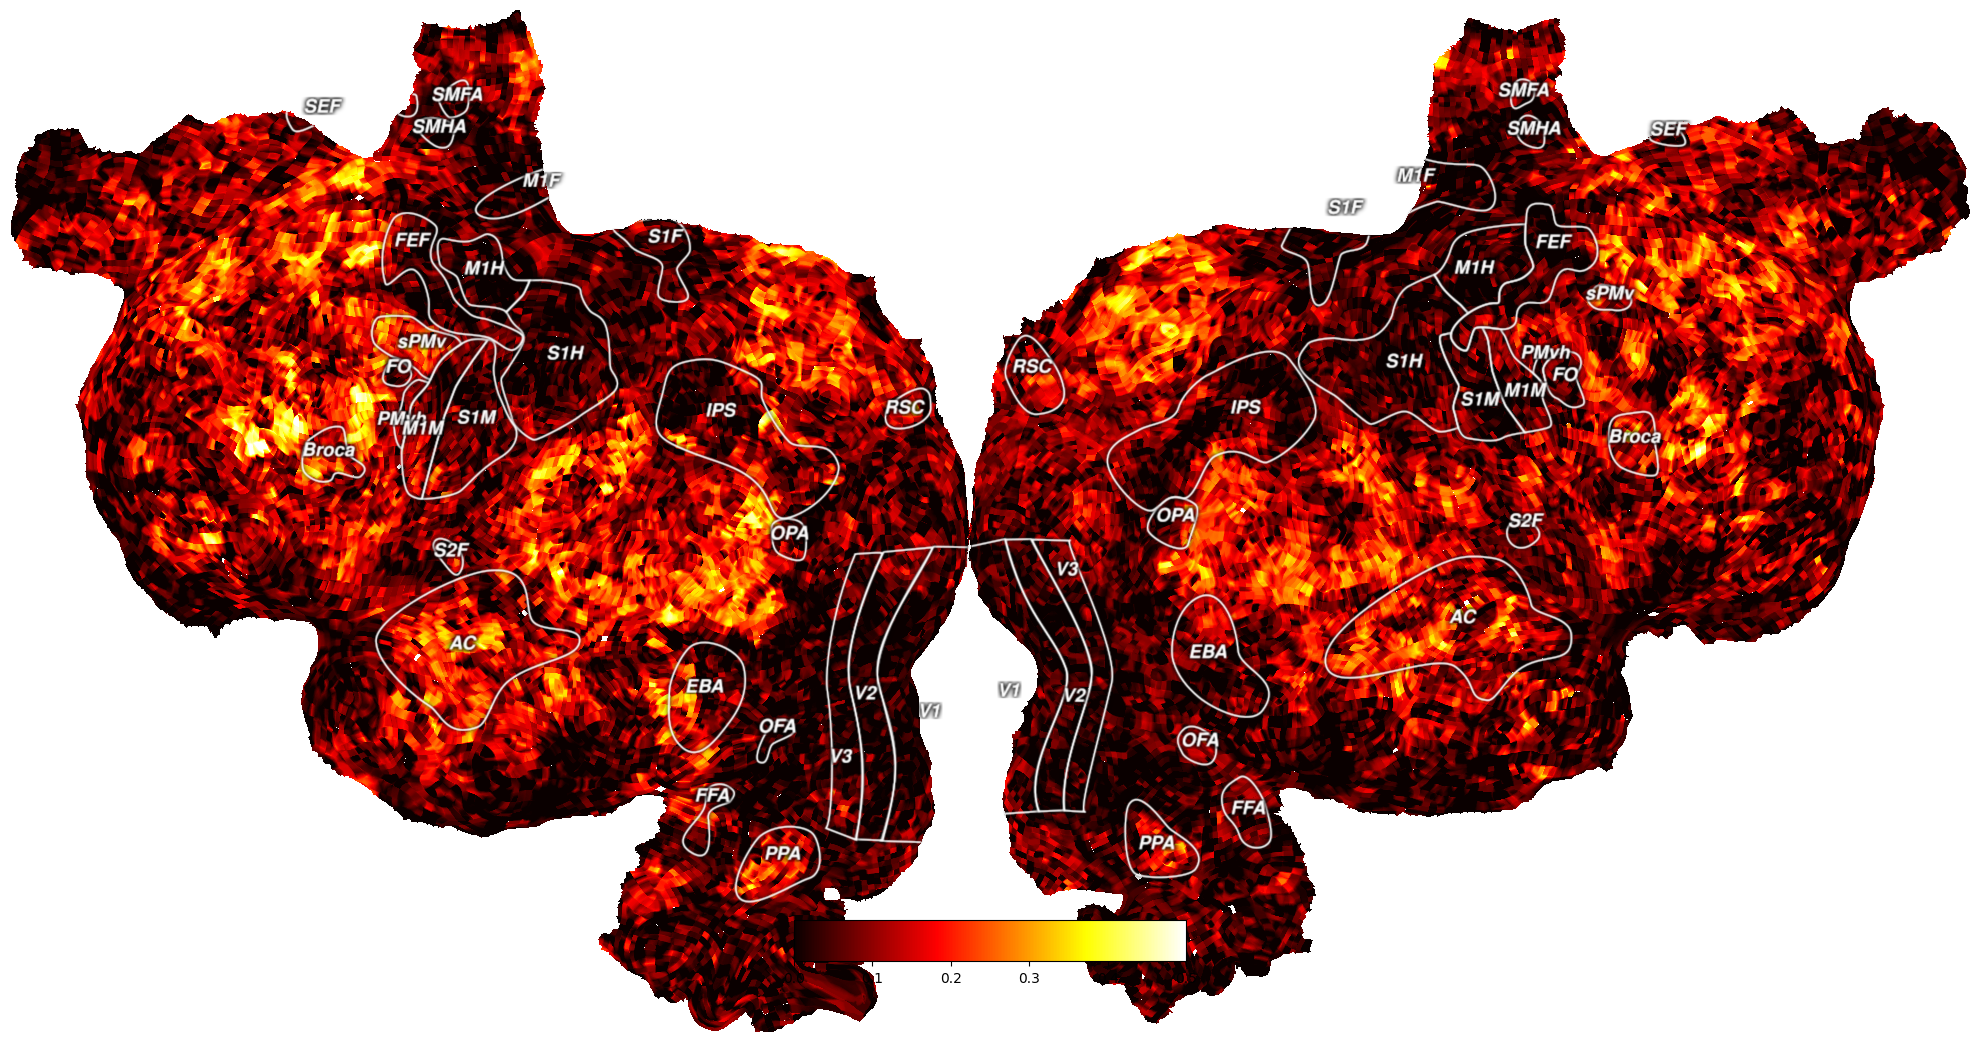

In [20]:
flatmap_quickshow(scores=meta['corr'], mask=meta['mask'])


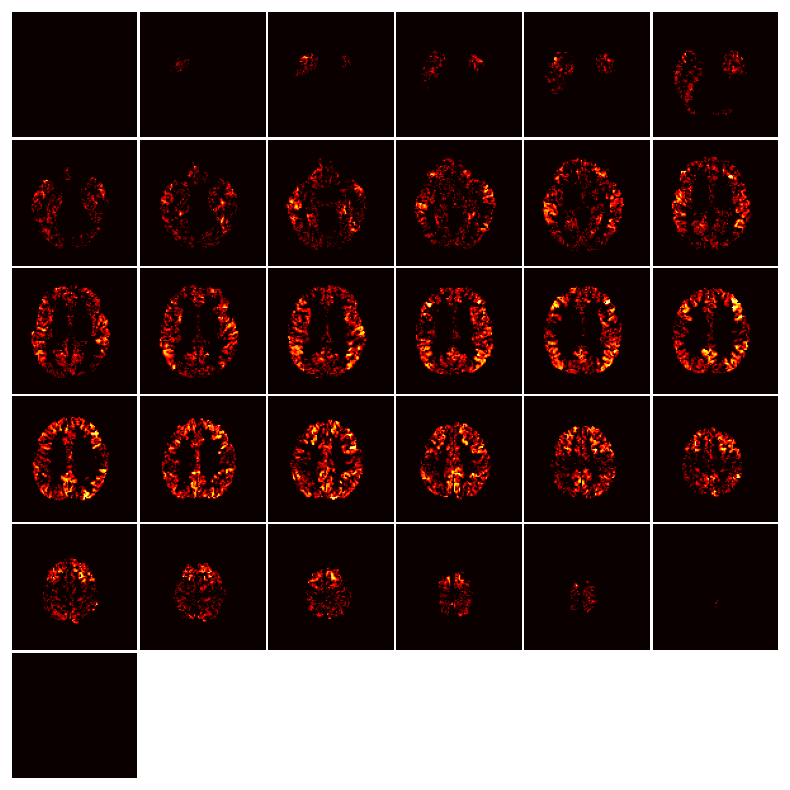

In [17]:

plot_mosaic(scores=meta['corr'], mask=meta['mask'])

# Preprocessing reference

Preprocess and load neuroscience data. Follow the tutorial at https://github.com/HuthLab/speechmodeltutorial then add the below cell to save out the outputs used here.

In [ ]:
# things to save: 37226 fit voxels
# corr (37226,)
# boolean mask (31, 100, 100) - 37226 True

# need to calculate (indexed in order of corrsort)
# corrsort (37226,) = np.argsort(corr)[::-1], best voxel index is corrsort[0]
# top_words (37226, 200) # top words activating this voxel
# top_word_scores (37226, 200) # score for each of top words activating this voxel

# show example plot (need to map back to mask ordering before this)
# Plot mosaic of correlations
# corrvolume = np.zeros(mask.shape)
# corrvolume[mask>0] = voxcorrs

"""
import pickle as pkl
pkl.dump({
    'corr': corr,
    'mask': mask,
    'corrsort': corrsort,
},
    open('voxels_metadata.pkl', 'wb'))

N = mask.sum()
N_WORDS = 200
N_RESTART = 1000
# top_words = [] # np.empty((N, N_WORDS), dtype='str')
top_words = pkl.load(open(f'best_voxels_top_words_{N_RESTART - 1}.pkl', 'rb'))['top_words'].tolist()
top_word_scores = np.empty((N, N_WORDS))

for i in tqdm(range(N_RESTART, N)):
    vox_num = corrsort[i]
    voxwords = eng1000.find_words_like_vec(udwt[:, vox_num], n=N_WORDS)
    top_word_scores[i, :] = [score for (score, word) in voxwords]
    top_words.append([word for (score, word) in voxwords])

    if i % 1000 == 999:
        pkl.dump({
            'top_word_scores': top_word_scores,
            'top_words': np.array(top_words),
        },
            open(f'best_voxels_top_words_{i}.pkl', 'wb'))
"""